# Домашнее задание. Классификация изображений

Сегодня вам предстоить помочь телекомпании FOX в обработке их контента. Как вы знаете, сериал "Симпсоны" идет на телеэкранах более 25 лет, и за это время скопилось очень много видеоматериала. Персоонажи менялись вместе с изменяющимися графическими технологиями, и Гомер Симпсон-2018 не очень похож на Гомера Симпсона-1989. В этом задании вам необходимо классифицировать персонажей, проживающих в Спрингфилде. Думаю, нет смысла представлять каждого из них в отдельности.



### Установка зависимостей

In [1]:
!pip install wheel==0.34.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: wheel
    Found existing installation: wheel 0.40.0
    Uninstalling wheel-0.40.0:
      Successfully uninstalled wheel-0.40.0


In [2]:
# установка подходящей версии torch

from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

  ERROR: HTTP error 403 while getting http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl
ERROR: Could not install requirement torch==0.4.1 from http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl because of HTTP error 403 Client Error: Forbidden for url: http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl for URL http://download.pytorch.org/whl/cu110/torch-0.4.1-cp39-cp39-linux_x86_64.whl


In [3]:
# we will verify that GPU is enabled for this notebook
# following should print: CUDA is available!  Training on GPU ...
# 
# if it prints otherwise, then you need to enable GPU: 
# from Menu > Runtime > Change Runtime Type > Hardware Accelerator > GPU

import torch
import numpy as np
import pandas as pd
import os.path
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.metrics import f1_score
from torchvision import  models
from pathlib import Path



train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/simpsons/train.zip -d train
!unzip -q /content/gdrive/My\ Drive/Colab\ Notebooks/simpsons/testset.zip -d test

In [6]:
!nvidia-smi
torch.cuda.is_available()

Tue Apr 18 09:18:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [8]:
#!pip install https://github.com/CellProfiling/HPA-Cell-Segmentation/archive/master.zip

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [7]:
import pickle
import numpy as np
import torch.nn as nn
from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader


from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки 
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [8]:
# разные режимы датасета 
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation. 

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample) 

In [9]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        if self.mode == 'test':
            transform = transforms.Compose([
                #transforms.RandomResizedCrop(244),
                #transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])
        else:
            transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
            ])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [10]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [11]:
TRAIN_DIR = Path('train/train')
TEST_DIR = Path('test/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [12]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.05, \
                                          stratify=train_val_labels)

In [13]:
val_dataset = SimpsonsDataset(val_files, mode='val')

In [ ]:
# uncomment if you have problem with pillow
# def register_extension(id, extension): Image.EXTENSION[extension.lower()] = id.upper()
# Image.register_extension = register_extension
# def register_extensions(id, extensions): 
#     for extension in extensions: register_extension(id, extension)
# Image.register_extensions = register_extensions

Давайте посмотрим на наших героев внутри датасета.

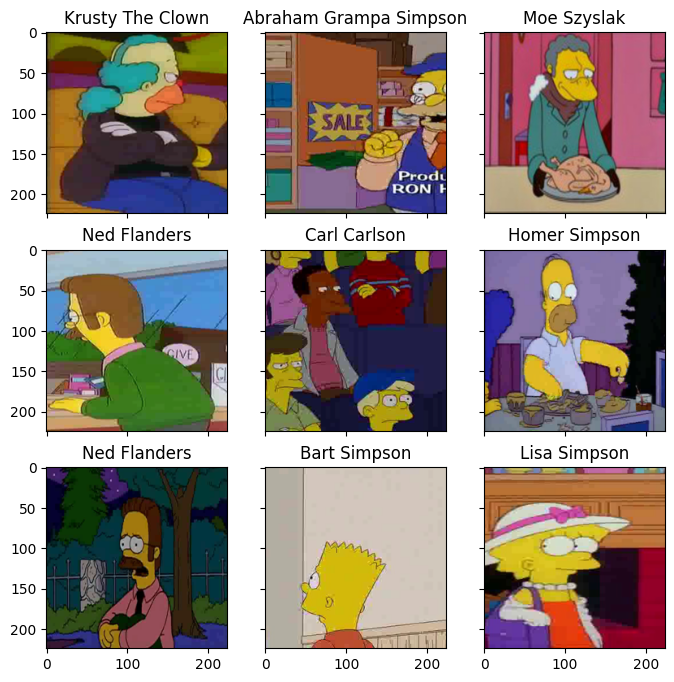

In [16]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

Можете добавить ваши любимые сцены и классифицировать их. (веселые результаты можно кидать в чат)

### Построение нейросети

Запустить данную сеть будет вашим мини-заданием на первую неделю, чтобы было проще участвовать в соревновании.

Данная архитектура будет очень простой и нужна для того, чтобы установить базовое понимание и получить простенький сабмит на Kaggle

<!-- Здесь вам предлагается дописать сверточную сеть глубины 4/5.  -->

*Описание слоев*:



1. размерность входа: 3x224x224 
2.размерности после слоя:  8x111x111
3. 16x54x54
4. 32x26x26
5. 64x12x12
6. выход: 96x5x5


In [ ]:
# Очень простая сеть
class SimpleCnn(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        self.eval_preds = []
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=8, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=96, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        self.out = nn.Linear(96 * 5 * 5, n_classes)
  
  
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)

        x = x.view(x.size(0), -1)
        logits = self.out(x)
        return logits

In [41]:
def fit_epoch(model, train_loader, criterion, optimizer, sheduler):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    sheduler.step()          
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [13]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [14]:
def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()

        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, )
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [15]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [ ]:
n_classes = len(np.unique(train_val_labels))
simple_cnn = SimpleCnn(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(simple_cnn)

Запустим обучение сети.

In [18]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')
    
train_dataset = SimpsonsDataset(train_files, mode='train')

In [ ]:
history = train(train_dataset, val_dataset, model=simple_cnn, epochs=2, batch_size=64)

Построим кривые обучения

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)

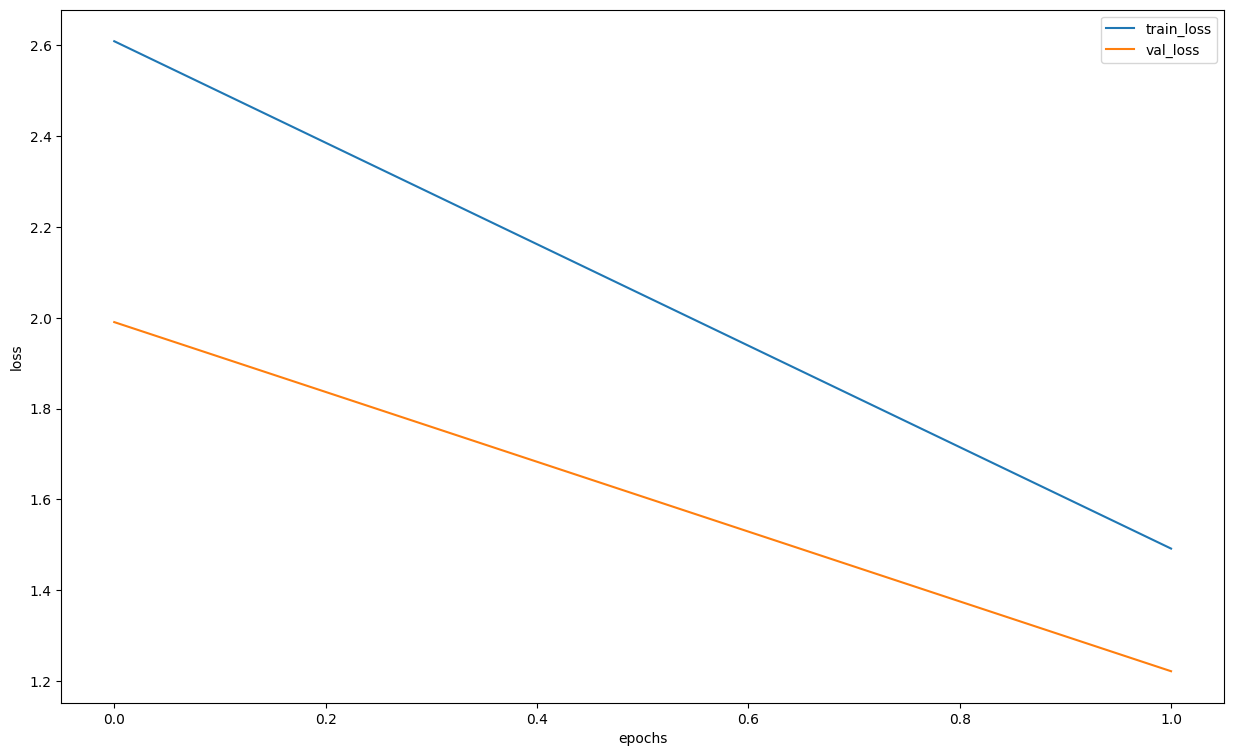

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Ну и что теперь со всем этим делать?

![alt text](https://www.indiewire.com/wp-content/uploads/2014/08/the-simpsons.jpg)

Хорошо бы понять, как сделать сабмит. 
У нас есть сеть и методы eval у нее, которые позволяют перевести сеть в режим предсказания. Стоит понимать, что у нашей модели на последнем слое стоит softmax, которые позволяет получить вектор вероятностей  того, что объект относится к тому или иному классу. Давайте воспользуемся этим.

In [ ]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [ ]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(simple_cnn, ex_img.unsqueeze(0))

In [ ]:
#idxs = list(map(int, np.random.uniform(0,1000, 20)))
idxs = list(map(int, np.random.uniform(0,5234, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)

In [17]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
preds_class

In [ ]:
y_pred

array([24, 15, 37, 28,  4, 22,  0,  7,  6, 18, 37, 32, 28, 25,  7, 20,  6,
        4, 20,  0])

In [ ]:
actual_labels

[24, 32, 37, 28, 21, 22, 0, 7, 6, 18, 37, 9, 0, 25, 4, 25, 24, 7, 20, 0]

Обратите внимание, что метрика, которую необходимо оптимизировать в конкурсе --- f1-score. Вычислим целевую метрику на валидационной выборке.

In [ ]:
f1_score(actual_labels, y_pred, average='micro')


0.6

Сделаем классную визуализацию,  чтобы посмотреть насколько сеть уверена в своих ответах. Можете исспользовать это, чтобы отлаживать правильность вывода.

In [ ]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    
    

    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)
    
    actual_text = "Actual : {}".format(img_label)
            
    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(simple_cnn, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)
    
    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)
            
    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

Попробуйте найти те классы, которые сеть не смогла расспознать. Изучите данную проблему, это понадобится в дальнейшем.

###<font size=6>Моя часть</font><br>
<br>
<hr>

Для начала посмотрим на те классы, с которыми у нашей модели проблемы.

In [ ]:
idxs = list(map(int, np.random.uniform(0,5234, 5234))) 
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(simple_cnn, imgs)
y_pred = np.argmax(probs_ims,-1)
actual_labels = [val_dataset[id][1] for id in idxs]
#preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
from sklearn.metrics import classification_report
print('\nClassification Report\n')
cl_report = classification_report(actual_labels, y_pred)
print(cl_report)


Classification Report

              precision    recall  f1-score   support

           0       0.81      0.59      0.68       218
           1       0.00      0.00      0.00        12
           2       0.73      0.71      0.72       164
           3       1.00      0.05      0.09        21
           4       0.46      0.65      0.54       337
           5       0.92      0.52      0.67        23
           6       0.77      0.48      0.59       321
           7       0.60      0.88      0.71       233
           8       1.00      0.25      0.40         4
           9       0.69      0.57      0.62       105
          11       0.63      0.52      0.57       117
          12       1.00      0.12      0.22         8
          13       0.00      0.00      0.00         3
          14       0.29      0.37      0.32        30
          15       0.63      0.80      0.71       555
          16       0.74      0.91      0.82       116
          17       0.75      0.87      0.80       303
   

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Как видно, кол-во экзмепляров у некоторых классов в валидационной выборки настолько мало, что невозможно корректно ориентироваться на f1 скор и другие метрики по ним, например 40, 26 или 19, а также и другие.

 Ради любопытсва посмотрим насколько хорошо они сбалансированы на train выборке.

In [ ]:


#Это первое что мне пришло в голову, когда я захотел сделать таблицу с кол-вом классовм
#Потом я посмотрел как это можно было сделать более изящно (реализовано ниже через пару ячеек)
sl = {'name': [], 'count': []}
path = 'train/train/simpsons_dataset'
with os.scandir(path) as files:
    subdir = [file.name for file in files if file.is_dir()]
for sub in subdir:
    folder_n = Path(path + '/' + sub)
    sum_n = sum(1 for x in folder_n.iterdir())
    #print(sub, sum_n)
    sl['name'].append(sub)
    sl['count'].append(sum_n)


In [18]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [ ]:
df = pd.DataFrame(data=sl)
df

,name,count
0,fat_tony,27
1,barney_gumble,105
2,homer_simpson,2246
3,troy_mcclure,8
4,miss_hoover,17
5,apu_nahasapeemapetilon,623
6,abraham_grampa_simpson,913
7,snake_jailbird,55
8,martin_prince,71
9,professor_john_frink,65


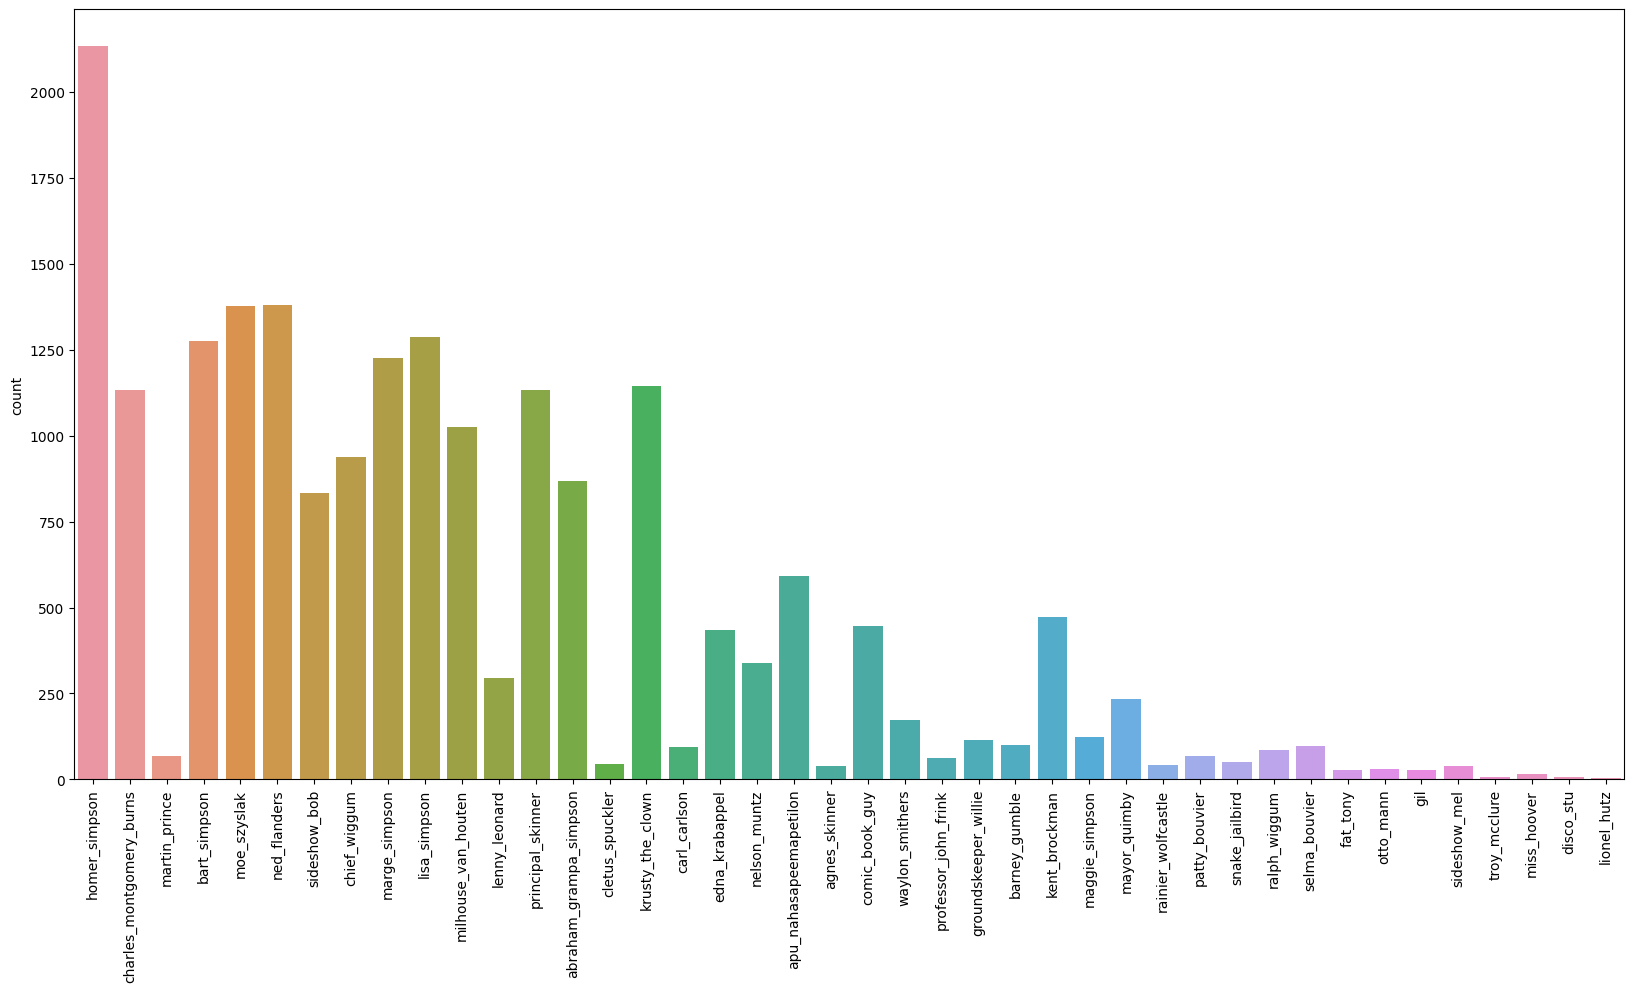

In [14]:
from collections import Counter
import seaborn as sns

data_dict = dict(Counter([x.parent.name for x in train_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

Как видно, классы не сбалансированны от слова совсем. 

Поэтому нам явно стоит воспользоваться преобразованием обучающих данных для расширения обучающей выборки.

In [25]:
augmenters = {
    'Crop_comb': transforms.Compose([
                                transforms.Resize(size=300, max_size=301),
                                transforms.CenterCrop(size=300),
                                transforms.RandomCrop(250)
                                ]),
    'Perspective': transforms.Compose([
        transforms.RandomPerspective(distortion_scale=0.3, p=1.0),
        transforms.Resize(size=300, max_size=301),
        transforms.CenterCrop(size=300),
        transforms.RandomCrop(250)
        ]),
                                       
    'Rotate': transforms.RandomRotation(degrees=(-25, 25)),
    'HFlip': transforms.RandomHorizontalFlip(p=1),
    'Comb1': transforms.Compose([transforms.RandomPerspective(distortion_scale=0.3, p=1.2),
                                  transforms.RandomHorizontalFlip(p=1),
                                 ]),
    'Comb2': transforms.Compose([transforms.RandomPerspective(distortion_scale=0.3, p=1.1),
                                 transforms.RandomHorizontalFlip(p=1),
                                 transforms.RandomRotation(degrees=(-25, 25)),
                                 transforms.Resize(size=300, max_size=301),
                                 transforms.CenterCrop(size=300),
                                 transforms.RandomCrop(250)
                                 ]),
    'Comb3': transforms.Compose([transforms.RandomPerspective(distortion_scale=0.2, p=1.2),
                                 transforms.RandomHorizontalFlip(p=1),
                                 transforms.RandomRotation(degrees=(-15, 15)),
                                 transforms.Resize(size=300, max_size=301),
                                 transforms.CenterCrop(size=300),
                                 transforms.RandomCrop(250),
                                 ]),
}

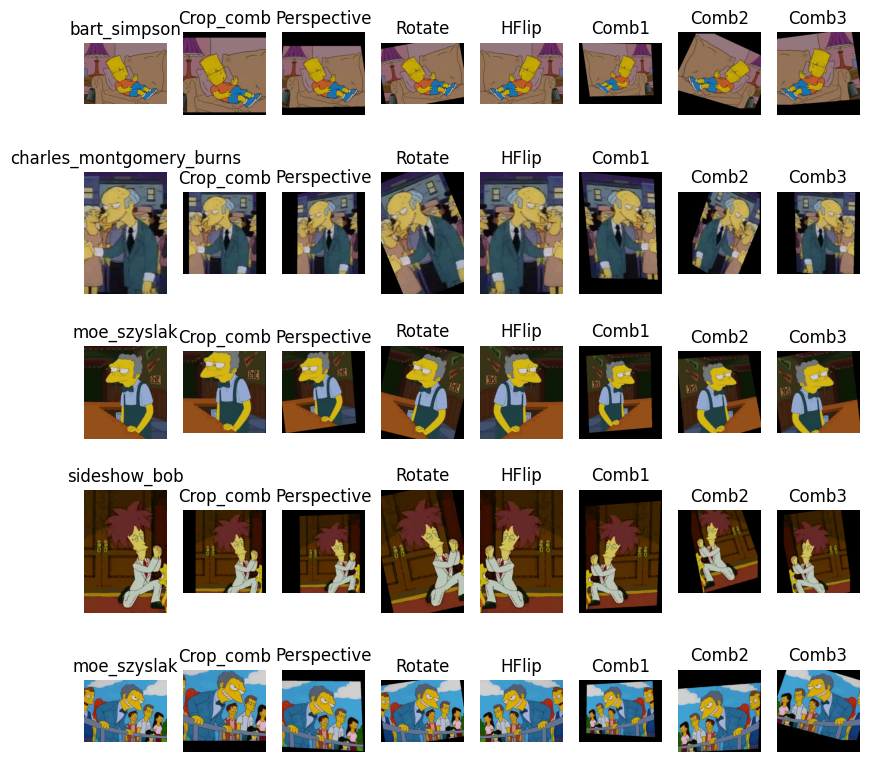

In [ ]:
train_dataset = SimpsonsDataset(train_files, mode='train')

fig, ax = plt.subplots(nrows=5, ncols=(len(augmenters) + 1),figsize=(10, 10))

for i in range(5):
    random_character = int(np.random.uniform(0, len(train_val_files)))
    img_orig = train_dataset.load_sample(train_val_files[random_character])
    img_label = train_val_files[random_character].parent.name
    
    ax[i][0].imshow(img_orig)
    ax[i][0].set_title(img_label)
    ax[i][0].axis('off')
        
    for j, (augmenter_name, augmenter) in enumerate(augmenters.items()):
        img_aug = augmenter(img_orig)
        ax[i][j + 1].imshow(img_aug)
        ax[i][j + 1].set_title(augmenter_name)
        ax[i][j + 1].axis('off')

Воспользуемся таким подходом:

Если число объектов класса больше 1500, то мы не будем ничего делать с ним, в обратном случае мы считаем сколько объктов нужно добавить к нему чтобы это число было равно ~ 1500 (столбец add). Далее считаем сколько минимально аугментаций можно сделать для объектов этого класса, чтобы получить это число (from_one_image). 

In [26]:
is_enght = data['count'] < 1500
data.loc[is_enght, 'add'] = (1500 - data['count']).astype(int)
data.loc[~is_enght, 'add'] = 0
data['from_one_image'] = (np.ceil(data['add'] / data['count'])).astype(int)
data

,count,add,from_one_image
sideshow_bob,833,667.0,1
edna_krabappel,434,1066.0,3
apu_nahasapeemapetilon,592,908.0,2
ned_flanders,1381,119.0,1
patty_bouvier,68,1432.0,22
homer_simpson,2134,0.0,0
bart_simpson,1275,225.0,1
moe_szyslak,1379,121.0,1
chief_wiggum,937,563.0,1
principal_skinner,1134,366.0,1


In [27]:
import random
create_dir = Path('../content/sample')

if not os.path.isdir(create_dir):
    os.mkdir(create_dir)

proc_dataset = SimpsonsDataset(train_files, mode='train')

for image_path in tqdm(train_files):
    path = image_path.parents[0]
    character = image_path.parent.name
    img = proc_dataset.load_sample(image_path)
    
    if data.loc[character]['add'] <= 0:
        continue
  
    if data.loc[character]['from_one_image'] > data.loc[character]['add']:
        iter_size = data.loc[character]['add']
    else:
        iter_size = data.loc[character]['from_one_image']
    data.loc[character]['add'] -= iter_size
    
    for i in range(int(iter_size)):
        
        parent_dir = Path('../content/sample')
        
        directory = character
        
        path = os.path.join(parent_dir, directory)
        
        if not os.path.isdir(path):
            os.mkdir(path)
        
        augmenter = random.choice(list(augmenters.values()))
        aug_img = augmenter(img)
        aug_img.save(f"{path}/{image_path.name.split('.')[0]}_{i}.jpg")

  0%|          | 0/19885 [00:00<?, ?it/s]<ipython-input-27-be16f9303b6e>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[character]['add'] -= iter_size
100%|██████████| 19885/19885 [07:51<00:00, 42.18it/s]


In [19]:
SAMPLE_DIR = Path('/content/sample')

In [20]:
train_sample_files = sorted(list(SAMPLE_DIR.rglob('*.jpg')))

sample_labels = [path.parent.name for path in train_val_files]

In [21]:
train_files.extend(train_sample_files)

In [22]:
len(train_files)

75353

После аугментации, можно наблюдать что дисбаланс классов значительно уменьшился.

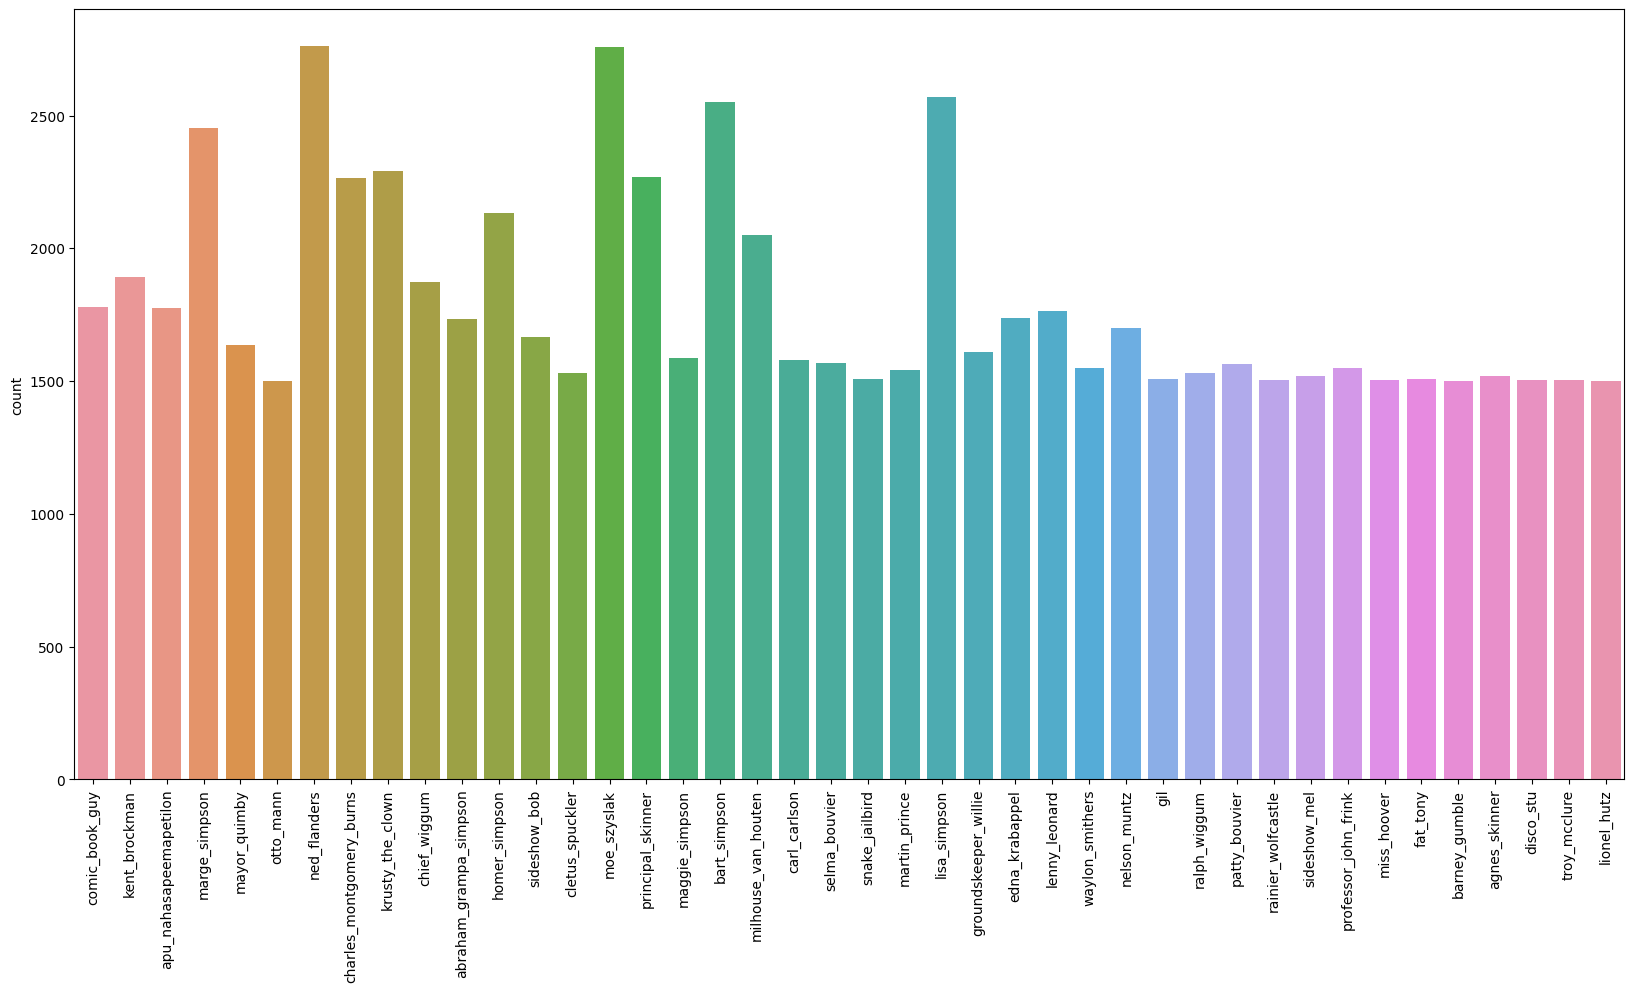

In [25]:
data_dict = dict(Counter([x.parent.name for x in train_files]))
data = pd.DataFrame(data = data_dict.values(), index=data_dict.keys(), columns=['count'])
plt.figure(figsize=(20,10))
sns.barplot(x = data.index, y = data['count']).set_xticklabels(data.index, rotation=90)
plt.show()

In [26]:
train_dataset = SimpsonsDataset(train_files, mode='train')

Будем использовать Feature Extractor в качестве средства извлечения признаков. Переобучать будем ResNet50

In [33]:
model_extractor = models.resnet50(pretrained=True)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 192MB/s]


In [ ]:
print(model_extractor)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
# замораживаем параметры (веса)
for param in model_extractor.parameters():
    param.requires_grad = False

model_extractor.fc = nn.Linear(2048, 42)
model_extractor.to(DEVICE)

optimizer = optim.Adam(model_extractor.fc.parameters(), lr=1e-4)
#exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [47]:
def train_model(train_files, val_files, model, scheduler, opt, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        criterion = nn.CrossEntropyLoss()
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt, scheduler)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history

In [ ]:
history = train_model(train_dataset, val_dataset, model=model_extractor, opt=optimizer, epochs=10, batch_size=256)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.6020458322150786


epoch:  10%|█         | 1/10 [10:06<1:30:56, 606.27s/it]


Epoch 001 train_loss: 2.6020     val_loss 2.3823 train_acc 0.5773 val_acc 0.5980
loss 2.135057216073675


epoch:  20%|██        | 2/10 [19:46<1:18:49, 591.21s/it]


Epoch 002 train_loss: 2.1351     val_loss 2.0263 train_acc 0.6500 val_acc 0.6292
loss 1.79801613831512


epoch:  30%|███       | 3/10 [29:22<1:08:09, 584.16s/it]


Epoch 003 train_loss: 1.7980     val_loss 1.7828 train_acc 0.6879 val_acc 0.6527
loss 1.5596233294831432


epoch:  40%|████      | 4/10 [39:01<58:11, 581.93s/it]


Epoch 004 train_loss: 1.5596     val_loss 1.6008 train_acc 0.7133 val_acc 0.6693
loss 1.3877629721445812


epoch:  50%|█████     | 5/10 [48:39<48:23, 580.78s/it]


Epoch 005 train_loss: 1.3878     val_loss 1.4815 train_acc 0.7322 val_acc 0.6832
loss 1.2583948246420984


epoch:  60%|██████    | 6/10 [58:15<38:36, 579.08s/it]


Epoch 006 train_loss: 1.2584     val_loss 1.3791 train_acc 0.7478 val_acc 0.6912
loss 1.158168118653442


epoch:  70%|███████   | 7/10 [1:07:53<28:55, 578.58s/it]


Epoch 007 train_loss: 1.1582     val_loss 1.3102 train_acc 0.7612 val_acc 0.6960
loss 1.0783881568940972


epoch:  80%|████████  | 8/10 [1:17:32<19:17, 578.63s/it]


Epoch 008 train_loss: 1.0784     val_loss 1.2523 train_acc 0.7727 val_acc 0.7012
loss 1.0133965207480502


epoch:  90%|█████████ | 9/10 [1:27:08<09:37, 577.83s/it]


Epoch 009 train_loss: 1.0134     val_loss 1.2092 train_acc 0.7828 val_acc 0.7071
loss 0.9588267949059762


epoch: 100%|██████████| 10/10 [1:36:43<00:00, 580.39s/it]


Epoch 010 train_loss: 0.9588     val_loss 1.1641 train_acc 0.7901 val_acc 0.7107


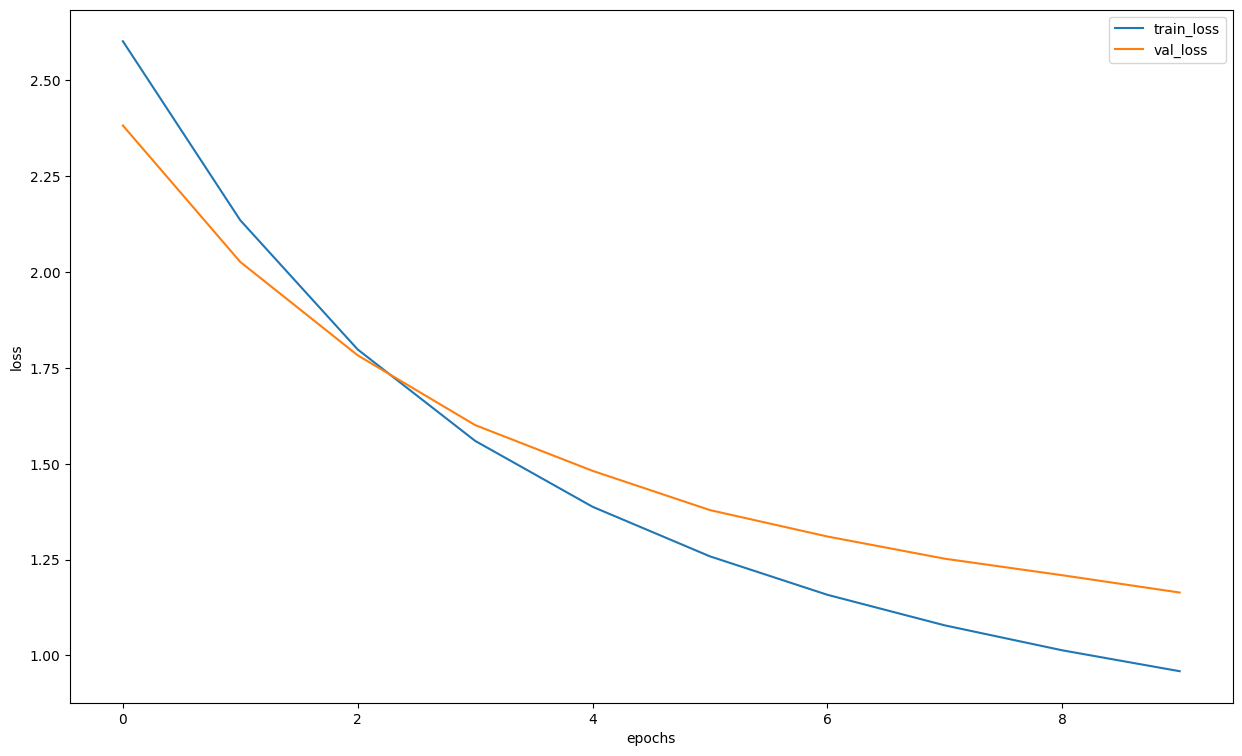

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [ ]:
idxs = list(map(int, np.random.uniform(0,1000, 300)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(model_extractor, imgs)

In [ ]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [ ]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [ ]:
f1_score(actual_labels, y_pred, average='micro')

0.7333333333333333

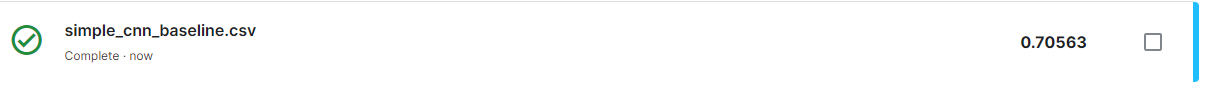

Результат не очень, тогда поробуем обучить сеть, на готовой архитектуре, используя sheduler, при этом попробуем взять не слишком глубокую сеть

In [42]:
model = models.resnet18(weights="IMAGENET1K_V1")

In [43]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [44]:
model.fc = nn.Linear(512, 42)
model.to(DEVICE)

optimizer = optim.Adam(lr=1e-4)
lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
history = train_model(train_dataset, val_dataset, model=model, scheduler=lr_scheduler, opt=optimizer, epochs=15, batch_size=100)

epoch:   0%|          | 0/15 [00:00<?, ?it/s]

loss 0.5545141996952422


epoch:   7%|▋         | 1/15 [3:57:31<55:25:26, 14251.88s/it]


Epoch 001 train_loss: 0.5545     val_loss 6.8417 train_acc 0.8994 val_acc 0.2693


##Важно
На данный момент, у меня закончились вычислительные мощности, спасибо гуглу, и пришлось вычислять на cpu. Привет эпохе по 4 часа)) Я гугл любит дропать тебя если что-то работает больше 5 часов.

Учитывая все вышеперечисленное, я решели посчитать на кагле, там тоже есть нотбуки c GPU. Использовал я там архитектуру 50resnet без предобученных весов, но с аугментацией и sheduler-ом, я был уверен что это сработает, поэтому уменьшил валидационную выборку до 5%. 

https://www.kaggle.com/code/ashenrain/simpsons-50resnet-shed-augm?scriptVersionId=126245567

Соответсвтенно, ответ для нынешнего скора я получил от туда

In [ ]:
loss, acc, val_loss, val_acc = zip(*history)
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

### Submit на Kaggle

![alt text](https://i.redd.it/nuaphfioz0211.jpg)

In [ ]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(model_mixed, test_loader)

preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]


In [ ]:
! ls 

gdrive	label_encoder.pkl  sample  sample_data	test  train


In [ ]:
import pandas as pd
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head(10)
#вывод ниже это от первой сетки, сразу же ошибка на второй картинке)

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,lisa_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon
5,img102.jpg,kent_brockman
6,img103.jpg,edna_krabappel
7,img104.jpg,chief_wiggum
8,img105.jpg,lisa_simpson
9,img106.jpg,kent_brockman


In [ ]:
my_submit.to_csv('../content/simple_cnn_baseline.csv', index=False)

Посмотри важное, если не понятно откуда взялся данный скор.

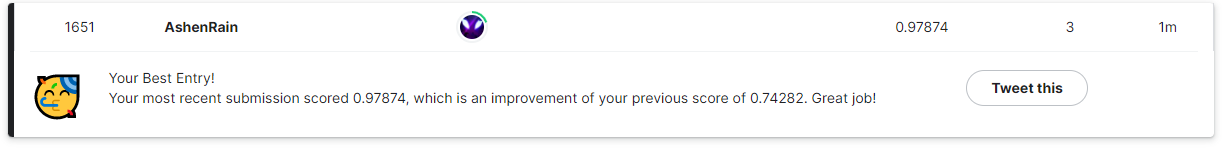

*Курсив*## Приключение?

А теперь самое интересное, мы сделали простенькую сверточную сеть и смогли отправить сабмит, но получившийся скор нас явно не устраивает. Надо с этим что-то сделать. 

Несколько срочныйх улучшейни для нашей сети, которые наверняка пришли Вам в голову: 


*   Учим дольше и изменяем гиперпараметры сети
*  learning rate, batch size, нормализация картинки и вот это всё
*   Кто же так строит нейронные сети? А где пулинги и батч нормы? Надо добавлять
*  Ну разве Адам наше все? [adamW](https://www.fast.ai/2018/07/02/adam-weight-decay/) для практика, [статейка для любителей](https://openreview.net/pdf?id=ryQu7f-RZ) (очень хороший анализ), [наши ](https://github.com/MichaelKonobeev/adashift/) эксперименты для заинтересованных.

* Ну разве это deep learning? Вот ResNet и Inception, которые можно зафайнтьюнить под наши данные, вот это я понимаю (можно и обучить в колабе, а можно и [готовые](https://github.com/Cadene/pretrained-models.pytorch) скачать).

* Данных не очень много, можно их аугументировать и  доучититься на новом датасете ( который уже будет состоять из, как  пример аугументации, перевернутых изображений)

* Стоит подумать об ансамблях


Надеюсь, что у Вас получится!

![alt text](https://pbs.twimg.com/profile_images/798904974986113024/adcQiVdV.jpg)
